### Karim Moumene AMROUCHE
### Neila ZAROUTA

# Imports

In [1]:
%%capture
!pip install pytorch-lightning
  

In [2]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pytorch_lightning as pl

from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


# Convolutional Neural Networks

For this homework you will train a CNN on the Hymenoptera dataset that you can download from here:

- https://download.pytorch.org/tutorial/hymenoptera_data.zip

You will code any CNN architecture that you want for this, using pytorch and/or pytorch-lightning (you can use only pytorch is you want)

## Load the dataset

**QUESTION.** Load the dataset into two dataloaders, one from training and the other for validation.

- You can use `torchvision.datasets.ImageFolder` and pass it to `DataLoader` for this, have a look at the documentation
- In the transformations, you should resize the images to make things faster (using the size of CIFAR-10's images for instance), and use some data augmentation (only for the training dataloader, of course) 

In [3]:
import zipfile
with zipfile.ZipFile("hymenoptera_data.zip","r") as zip_ref:
    zip_ref.extractall("")

In [4]:
train = torchvision.datasets.ImageFolder(
    root = './hymenoptera_data/train/',
    transform = transforms.Compose([ 
         
        transforms.Resize((32,32)),                                                                 
        transforms.ToTensor()                                 
    ])
)

valid = torchvision.datasets.ImageFolder(
    root = './hymenoptera_data/val/',
    transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()                                 
    ])
)

In [5]:
num_workers = 16

hym_train_loader = DataLoader(train, batch_size=6, num_workers=num_workers, shuffle=True)
hym_valid_loader = DataLoader(valid, batch_size=64, num_workers=num_workers)

classes = train.classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**QUESTION.** Display some images and their associated labels. You should see images of bees and ants :)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


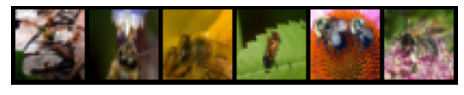

 ants     bees     bees     ants     bees     bees


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

hym_train_iter = iter(hym_train_loader)
images, labels = next(hym_train_iter)
show_images(torchvision.utils.make_grid(images))
print('    '.join('%5s' % classes[labels[j]] for j in range(6)))



---



---



In [7]:
class DataModule(pl.LightningDataModule):
    """DATA MODULE
    """

    def __init__(self, data_dir: str = './', image_size: int = 224, batch_size: int = 128, num_workers: int = 2,
                 val_size: float = 0.2, **kwargs):
        super().__init__()
        self.data_dir = data_dir
        self.transform_train = transforms.Compose([
            transforms.Resize((image_size + 4, image_size + 4)),
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        self.transform_test = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_size = val_size

        self.dims = (3, image_size, image_size)

    def setup(self, stage: str = None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            dataset = ImageFolder(f"{self.data_dir}/train", transform=self.transform_train)
            val_size = int(len(dataset) * self.val_size)
            self.dataset_train, self.dataset_val = random_split(dataset, [len(dataset) - val_size, val_size])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.dataset_test = ImageFolder(f"{self.data_dir}/val", transform=self.transform_test)

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [8]:
datamodule = DataModule(data_dir="hymenoptera_data", num_workers=2, batch_size=16)
datamodule.setup()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


## Neural net architecture

You are free to define any kind of convolutional neural network that you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [9]:
class ConvNet(nn.Module):
    def __init__(self, ):
        super(ConvNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1024, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=16, out_features=8, bias=True),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=8, out_features=1, bias=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [10]:
@torch.no_grad()
def eval_classifier(model, dataloader, criterion, device):
    model.eval()
    loss = []
    pred = []
    y_true = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x).flatten()
        loss.append(criterion(logits, y.float()).item())
        pred += (logits > 0.5).long().cpu().detach().numpy().flatten().tolist()
        y_true += y.cpu().detach().numpy().flatten().tolist()
    acc = accuracy_score(y_true=y_true, y_pred=pred)
    return np.mean(loss), acc

def train_classifier(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=int(1e2),
        random_seed= 47,
):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    if torch.cuda.is_available():
        device = torch.device("cuda")
        torch.backends.cudnn.benchmark = True
    else:
        device = torch.device("cpu")

    model = model.to(device)
    model = nn.DataParallel(model)

    pbar = tqdm(range(epochs), total=epochs)
    for epoch in pbar:
        model.train()
        epoch_loss = []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x).flatten()
            loss = criterion(y_hat.flatten(), y.float())
            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()

        train_loss, train_acc = eval_classifier(model, train_loader, criterion, device)
        test_loss, test_acc = eval_classifier(model, val_loader, criterion, device)

        pbar.set_description(
            f'Epoch: {epoch}, Train Loss: {np.round(train_loss, 3)} Acc: {np.round(train_acc, 3)}\tTest Loss: {np.round(test_loss, 3)} Acc: {np.round(test_acc, 3)}')


## Training loop and checks

**QUESTION**. Code the training loop (specify the loss, etc.). Check that everything is fine, that the forward pass works and that training on a very small subset of the data works as well. Add the callbacks that you want, and prepare the logging tools that you want to use (such as tensorboard, or anything you want to use.

In [11]:
criterion = nn.BCEWithLogitsLoss()

In [12]:
net_1 = ConvNet()
optimizer_1 = optim.Adam(net_1.parameters(), lr=0.001)

In [13]:
train_classifier(
    model= net_1,
    train_loader= datamodule.train_dataloader(),
    val_loader= datamodule.val_dataloader(),
    criterion= criterion,
    optimizer= optimizer_1,
    epochs=int(1e2)
)

  0%|          | 0/100 [00:00<?, ?it/s]

## Measure the performance of you model

Measure the performance of your model, and display some things (such as confusion matrix, ROC or AUC curves).
Compare several architectures, put your results in an easy to interpret pandas dataframe.

In [14]:
def conf_mat(model, dataloader):
  pred = []
  y_true = []
  classes = ('Bee','Ant')
  device = torch.device("cuda")
  for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x).flatten()
        pred += (logits > 0.5).long().cpu().detach().numpy().flatten().tolist()
        y_true += y.cpu().detach().numpy().flatten().tolist()
  r_curve = roc_curve(y_true, pred)
  cf_matrix = confusion_matrix(y_true, pred, normalize='true')
  df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes], columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  plt.title('Confusion matrix')
  sn.heatmap(df_cm, annot=True)

def plot_roc_cur(model, dataloader):  
    pred = []
    y_true = []
    classes = ('Bee','Ant')
    device = torch.device("cuda")
    for x, y in dataloader: 
        x, y = x.to(device), y.to(device)
        logits = model(x).flatten()
        pred += (logits > 0.5).long().cpu().detach().numpy().flatten().tolist()
        y_true += y.cpu().detach().numpy().flatten().tolist()
    fper, tper, thresholds = roc_curve(y_true, pred)
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


## Use fine-tuning and transfer learning

You might have noticed that training a CNN from scratch can be very slow, hard, painful, and that the overall performance might not be satisfying. 

**QUESTION.** To overcome this, use a pre-trained network and fine-tune it on the Hymenoptera dataset.
You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.

In [15]:
class FinTunedVGG(nn.Module):
    def __init__(self, ):
        super(FinTunedVGG, self).__init__()

        self.encoder = torchvision.models.vgg11(pretrained=True, progress=True).features

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=1, bias=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [16]:
net_2 = FinTunedVGG()
optimizer_2 = optim.Adam(net_2.parameters(), lr=0.001)

In [17]:
train_classifier(
    model= net_2,
    train_loader= datamodule.train_dataloader(),
    val_loader= datamodule.val_dataloader(),
    criterion= criterion,
    optimizer= optimizer_2,
    epochs=int(1e2)
)

  0%|          | 0/100 [00:00<?, ?it/s]

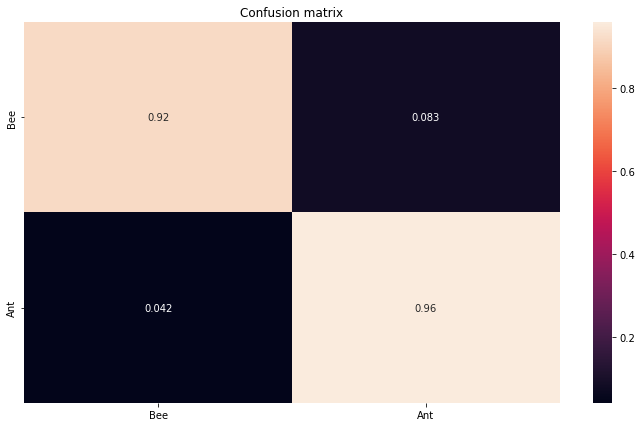

In [18]:
conf_mat(net_2, datamodule.val_dataloader())

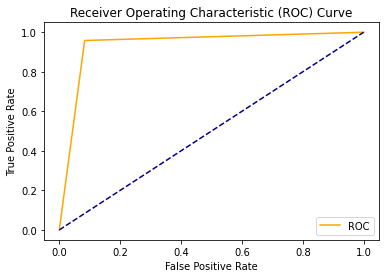

In [19]:
plot_roc_cur(net_2, datamodule.val_dataloader())